## Fake news detection

### How to spot fake news

1. consider the source
- click away from the story to investigate the site, its mission and its contact info

2. check the author
- do a quick search on the author, are they credible/real?

3. check the date
- re-posting old news stories doesn't mean they're relevant to current events

4. check your bias
- consider if your own beliefs could affect your judgement

5. read beyond
- headlines can be outrageous in an effort to get clicks, what's the whole story?

6. supporting sources?
- click on those links, determine if the info given actually supports the story

7. is it a joke?
- if it's too outlandish, it might be satire, research the site and author to be sure

8. ask the experts
- ask a librarian, or consult a fact-checking site

#### Import dependencies

In [ ]:
import itertools
import pandas as pd
import numpy as np
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

#### Import data

In [ ]:
train_data = pd.read_csv("./train_data.csv", index_col="id")
test_data = pd.read_csv("./test_data.csv", index_col="id")

print(train_data.head(3))

#### Data preprocessing

In [ ]:
x_train = train_data['text'].fillna(' ')
y_train = train_data['label'].to_frame()
x_test = test_data['text'].fillna(' ')
y_test = test_data['label'].to_frame()

In [ ]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', strip_accents='ascii')

In [ ]:
x_test = x_test.to_numpy()
x_test = x_test.ravel()

In [ ]:
tfidf_train = tfidf_vectorizer.fit_transform(x_train)
print(tfidf_vectorizer.get_feature_names_out())
tfidf_test = tfidf_vectorizer.transform(x_test)
print(tfidf_vectorizer.get_feature_names_out())

In [ ]:
print(type(tfidf_train))
print(type(tfidf_test))

In [ ]:
print(tfidf_train)

In [ ]:
print(tfidf_test)

### Model Implementations

#### 1. Passive agressive classifier

In [ ]:
pac = PassiveAggressiveClassifier(max_iter=50)
pac.fit(tfidf_train, y_train['label'].values)
print(y_test.count())

In [ ]:
y_pred = pac.predict(tfidf_test)
score = accuracy_score(y_test.to_numpy(), y_pred.ravel())
print(f"Accuracy: {round(score*100,2)}%")
print(confusion_matrix(y_test, y_pred, labels=[0,1]))

#### 2. Logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression()
LR.fit(tfidf_train, y_train['label'].values)

y_pred = LR.predict(tfidf_test)

print("accuracy: {}%".format(round(accuracy_score(y_test, y_pred.ravel())*100,2)))
print(confusion_matrix(y_test, y_pred, labels=[0,1]))

#### 3. Decision tree classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
DTC = DecisionTreeClassifier()
DTC.fit(tfidf_train, y_train['label'].values)

y_pred = DTC.predict(tfidf_test)

print("accuracy: {}%".format(round(accuracy_score(y_test, y_pred.ravel())*100,2)))
print(confusion_matrix(y_test, y_pred, labels=[0,1]))

#### 4. Random forest classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier()
RFC.fit(tfidf_train, y_train['label'].values)

y_pred = RFC.predict(tfidf_test)

print("accuracy: {}%".format(round(accuracy_score(y_test, y_pred.ravel())*100,2)))
print(confusion_matrix(y_test, y_pred, labels=[0,1]))

### Aviod fake news

1. check the source
- is ir a .com? .org? .edu or .gov? is the source from Google search or do you see an academic database?

2. use the CRAAP test
- Currency, Relevance, Accuracy, Authority, and Purpose

3. Check the claims in the article
- can you follow up with them using reputable sources?

4. Question everything
- does the site have ads? is the source from a think tank or non-profit that has a stake in the subject of the article? what's the author's background?

5. Check any links in the article
- do they actually lead to information that verifies something in the article?

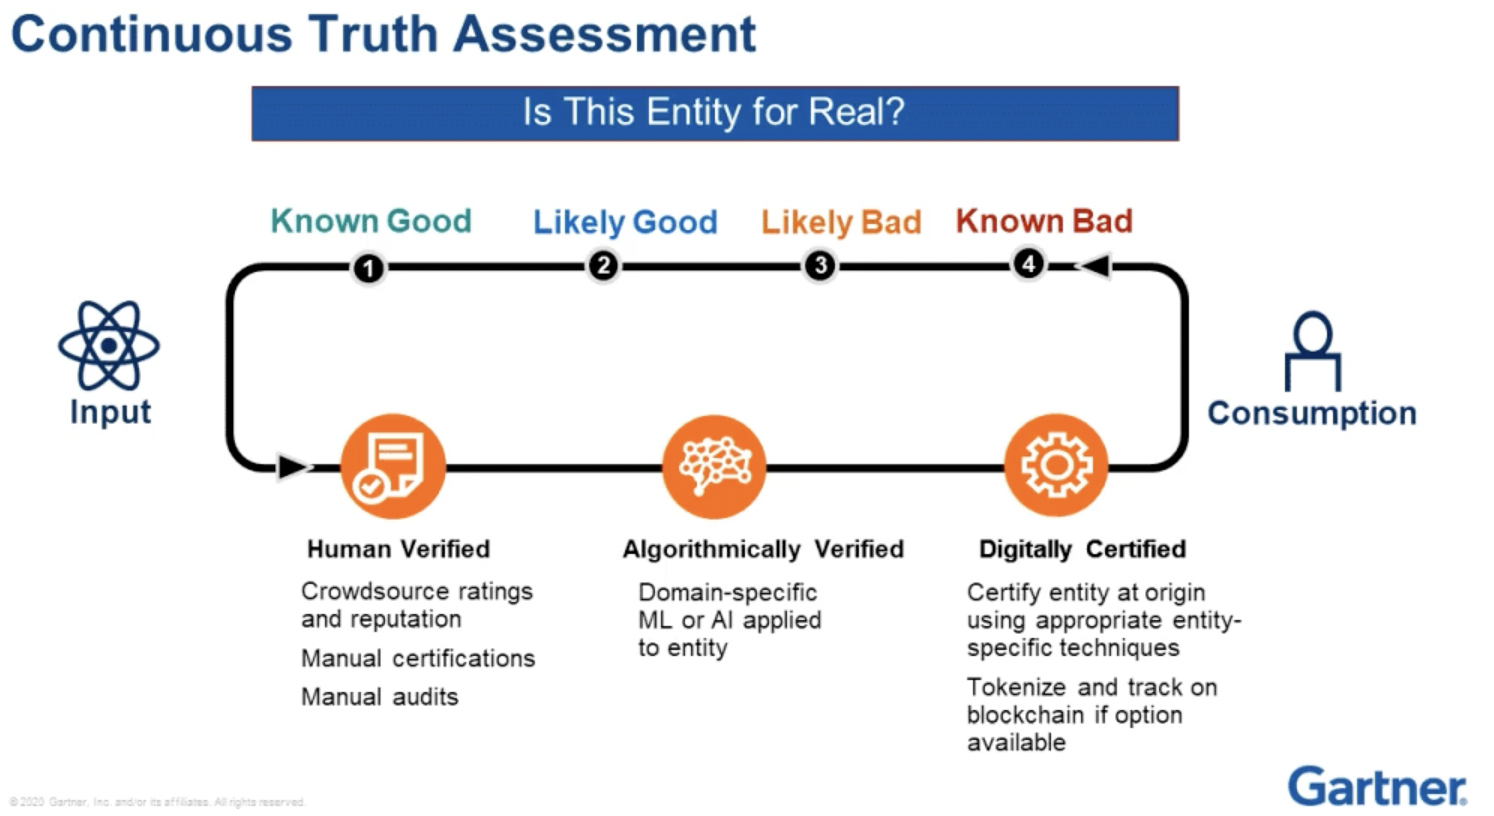

### 5. Deep learning

#### Import dependencies

In [ ]:
import itertools
import pandas as pd
import numpy as np

import tensorflow as tf
import random
import matplotlib.image as mimg
import matplotlib.pyplot as plt
import io

In [ ]:
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

In [ ]:
import collections
import pathlib
import re
import string
import random

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras import utils
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [ ]:
import tensorflow_datasets as tfds
# import tensorflow_text as tf_text
import os

#### Data preprocessing

In [ ]:
vocab_size = 10000

dtype = {
    "text": "str",
    "label": "uint8",
}

random.seed(87)

seed = random.randint(0, 100)

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    r'/Users/xinyue/Downloads/Rhyme Fake News Detection/go/train', batch_size=16, 
    shuffle=True, validation_split=0.3, 
    seed=seed, subset='training',
)

raw_val_ds = preprocessing.text_dataset_from_directory(
    r'/Users/xinyue/Downloads/Rhyme Fake News Detection/go/train', batch_size=16, 
    shuffle=True, validation_split=0.3, 
    seed=seed, subset='validation',
)

#### Create a text vectorization layer

In [ ]:
MAX_SEQUENCE_LENGTH = 250

int_vectorize_layer = TextVectorization(
    max_tokens = vocab_size,
    output_mode = 'int',
    output_sequence_length = MAX_SEQUENCE_LENGTH
)

train_text = raw_train_ds.map(lambda text, labels: text)
print(train_text)

int_vectorize_layer.adapt(train_text)

In [ ]:
def int_vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return int_vectorize_layer(text), label

In [ ]:
text_batch, label_batch = next(iter(raw_train_ds))
first_question, first_label = text_batch[0], label_batch[0]

In [ ]:
int_train_ds = raw_train_ds.map(int_vectorize_text)
int_val_ds = raw_val_ds.map(int_vectorize_text)

#### Optional auto-tune

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

def configure_dataset(dataset):
    return dataset.cache().prefetch(buffer_size=AUTOTUNE)

int_train_ds = configure_dataset(int_train_ds)
int_val_ds = configure_dataset(int_val_ds)

In [ ]:
def create_model(vocab_size, num_labels):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size+1, 128, mask_zero = True),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv1D(64, 5, padding = 'valid', activation = tf.keras.activations.selu, strides = 2),
        tf.keras.layers.MaxPooling1D(pool_size=4),
        tf.keras.layers.LSTM(20, return_sequences=True),
        tf.keras.layers.LSTM(20),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(512, activation = tf.keras.activations.selu),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(256, activation = tf.keras.activations.selu),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation = 'sigmoid')
    ])
    return model

model = create_model(vocab_size=vocab_size+1, num_labels=2)

In [ ]:
model.trainable = True

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), 
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), 
    metrics=tf.keras.metrics.BinaryAccuracy()
)

history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=50)

model.summary()

In [ ]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    r'/Users/xinyue/Downloads/Rhyme Fake News Detection/go/train',
    shuffle = True,
    seed = random.randint(0, 100)
)

int_test_ds = raw_test_ds.map(int_vectorize_text)
int_test_ds = configure_dataset(int_test_ds)

In [ ]:
loss, accuracy = model.evaluate(int_test_ds, callbacks=tf.keras.callbacks.BaseLogger())
print("Eval Loss: ", loss)
print("Evaluation Accuracy: {:2.2%}".format(accuracy))
print("History Accuracy: {:2.2%}".format(float(history.history['binary_accuracy'][-1])))
print("History Validation Accuracy: {:2.2%}".format(float(history.history['val_binary_accuracy'][-1])))

In [ ]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc = 'upper left')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc = 'upper right')
plt.show()

#### Save weights and model

In [ ]:
model.save_weights('weights')
model.save('model')

#### Reload weights and model

In [ ]:
export_model = tf.keras.models.load_model('model')
export_model.load_weights('weights')

export_model = tf.keras.Sequential([int_vectorize_layer, export_model])